# Machine Learning with R

## Practice Guide

我们选用Random Forest模型作为示例讲解机器学习。

### 1) 加载所需R package

运行代码之前需要以下 R packages

* [randomForest](https://cran.r-project.org/web/packages/randomForest/index.html): 构建Random Forest模型
* [ROCR](https://cran.r-project.org/web/packages/ROCR/index.html): 绘制ROC曲线和计算AUC
* [GGally](https://cran.r-project.org/web/packages/GGally/index.html): 画图表示特征之间相关性
* [mlbench](https://cran.r-project.org/web/packages/mlbench/index.html): 常用机器学习数据集

以下代码加载所需的R package。`require()`函数判断每个package是否已经安装。
如果未安装该package，则调用`install.packages()`安装。

In [23]:
for(pkg in c('randomForest', 'ROCR', 'GGally', 'mlbench')){
  if(!require(pkg, character.only=TRUE)){
    install.packages(pkg)
  }
}

设置随机数种子保证本教程的结果可重复

In [2]:
set.seed(1234) 

### 2) 加载数据集

我们采用R内置的数据集`iris`，其中包含4个特征和3个类别。每个类别包含50个样本，对应一个花的物种。数据集一共包含150个样本。

In [3]:
head(iris)

Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa


为简单起见，我们只选用`versicolor`和`virginica`两类做二分类问题。

In [4]:
# 去除类别为setosa的样本
df <- iris[iris$Species != 'setosa', ]
# 去除行的名称，让输出更为简洁
rownames(df) <- NULL
# 去除最后一列Species，产生输入矩阵
all_data <- df[, 1:(ncol(df) - 1)]
# 需要预测的类别向量。factor函数用于把原来的3种类别编程2中类别
all_classes <- factor(df$Species)

### 3) 划分训练集和测试集

我们随机选择80%的样本（80个样本）作为训练集，剩余20%的样本作为测试集。

In [5]:
# 总样本数为输入矩阵的行数
n_samples <- nrow(all_data)
# 计算训练集样本数(80%)
n_train <- floor(n_samples * 0.8)  # Calculate the size of training sets

# 产生所有样本序号的重新排列
indices <- sample(1:n_samples)
# 从以上随机排列中选取n_train个作为训练集样本序号
indices <- indices[1:n_train]

查看前10个训练集样本序号：

In [6]:
print(indices[1:10])

 [1] 12 62 60 61 83 97  1 22 99 47


In [7]:
# 选取训练集样本
train_data <- all_data[indices,]
train_classes <- all_classes[indices]
# 选取测试集样本，-indices表示选取序号不在indices中的样本
test_data <- all_data[-indices,]
test_classes <- all_classes[-indices]

### 4) 模型训练

以下代码在训练集上训练一个由100棵分类树组成的Random Forest模型：

In [8]:
rf_classifier = randomForest(train_data, train_classes, trees = 100, importance = TRUE)

函数返回的变量`rf_classifier`包含了已经训练好的模型：

In [9]:
rf_classifier


Call:
 randomForest(x = train_data, y = train_classes, importance = TRUE,      trees = 100) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 8.75%
Confusion matrix:
           versicolor virginica class.error
versicolor         36         3  0.07692308
virginica           4        37  0.09756098

### 5) 模型测试和评估

模型训练完成之后，可用`predict`函数在测试集上进行预测：

In [10]:
predicted_classes <- predict(rf_classifier, test_data)

In [11]:
print(test_classes)

 [1] versicolor versicolor versicolor versicolor versicolor versicolor
 [7] versicolor versicolor versicolor versicolor versicolor virginica 
[13] virginica  virginica  virginica  virginica  virginica  virginica 
[19] virginica  virginica 
Levels: versicolor virginica


In [12]:
print(predicted_classes)

         5          6          7         14         20         27         29 
versicolor versicolor versicolor versicolor versicolor versicolor versicolor 
        30         31         43         45         51         55         56 
versicolor versicolor versicolor versicolor  virginica  virginica  virginica 
        57         66         68         85         89         91 
versicolor  virginica  virginica  virginica  virginica  virginica 
Levels: versicolor virginica


用预测的类别和真实类别可构建一个混淆矩阵（confusion matrix）

In [13]:
# 定义versicolor为正类别
positive_class <- 'versicolor'
# true positive count (TP)
TP <- sum((predicted_classes == positive_class) & (test_classes == positive_class))
# false positive count (FP)
FP <- sum((predicted_classes == positive_class) & (test_classes != positive_class))
# false negative count (FN)
FN <- sum((predicted_classes != positive_class) & (test_classes == positive_class))
# true negative count (TN)
TN <- sum((predicted_classes != positive_class) & (test_classes != positive_class))
# 构建2x2矩阵，填充以上计算的四个数
confusion <- matrix(c(TP, FP, FN, TN), nrow=2, ncol=2, byrow=TRUE)
colnames(confusion) <- c('True versicolor', 'True virginica')
rownames(confusion) <- c('Predicted versicolor', 'Predicted virginica')
confusion

,True versicolor,True virginica
Predicted versicolor,11,1
Predicted virginica,0,8


关于混淆矩阵的计算，可参考(https://en.wikipedia.org/wiki/Confusion_matrix) 获得更多信息。

我们可以基于混淆矩阵计算accuracy、sensitivity、positive predicted value、specificity等评估指标：

In [14]:
cat('accuracy =', (TP + TN)/(TP + TN + FP + FN), '\n')
cat('sensitivity =', TP/(TP + FN), '\n')
cat('positive predicted value =', TP/(TP + FP), '\n')
cat('specificity =', TN/(TN + FP), '\n')

accuracy = 0.95 
sensitivity = 1 
positive predicted value = 0.9166667 
specificity = 0.8888889 


### 6) ROC曲线

ROC曲线需要两组数据：真实类别和预测某一类别的概率。
首先，调用`predict`函数时加上`type = 'prob'`参数可计算每个类别的概率

In [15]:
predicted_probs <- predict(rf_classifier, test_data, type = 'prob')

`predicted_probs`包含两列，对应两个类别

In [16]:
head(predicted_probs)

,versicolor,virginica
5,0.964,0.036
6,1.000,0.000
7,0.958,0.042
14,0.992,0.008
20,1.000,0.000
27,0.880,0.120


因为我们把`vesicolor`当作正样本，所以只选取预测为正样本的概率来计算ROC：

In [17]:
# 创建一个长度与测试集大小相同的0-1向量，1代表要预测的类别
test_labels <- vector('integer', length(test_classes))
test_labels[test_classes != positive_class] <- 0
test_labels[test_classes == positive_class] <- 1
# 通过prediction函数，使用预测为正样本的概率和真实类别创建一个对象pred
pred <- prediction(predicted_probs[, positive_class], test_labels)

以假阳性率（false positive rate, fpr)为X轴, 真阳性率（true positive rate, tpr）为y轴绘制ROC曲线：

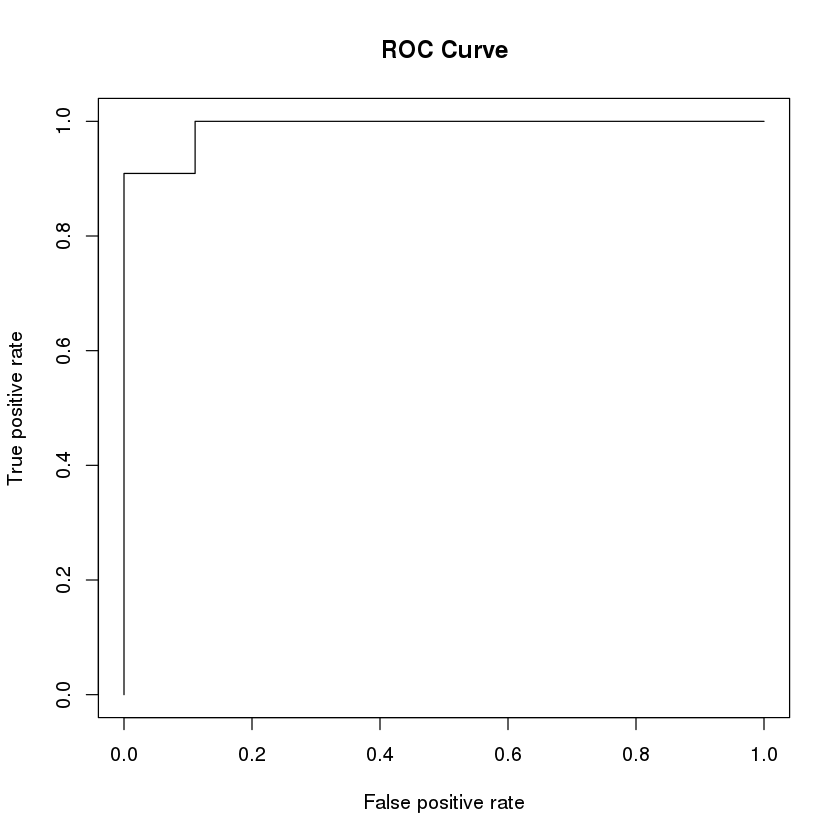

In [18]:
roc <- performance(pred, 'tpr', 'fpr') 
plot(roc, main = 'ROC Curve') 

计算ROC曲线下面积（area under the curve, AUC）：

In [19]:
auc <- performance(pred, 'auc')@y.values[[1]]
cat('auc =', auc, '\n')

auc = 0.989899 


## Tips

### 特征之间相关性

在模型训练之前，可以计算特征之间相关性，去除冗余的特征。注意特征数较多时，由于计算量很大，不适合分析所有特征之间的相关性。

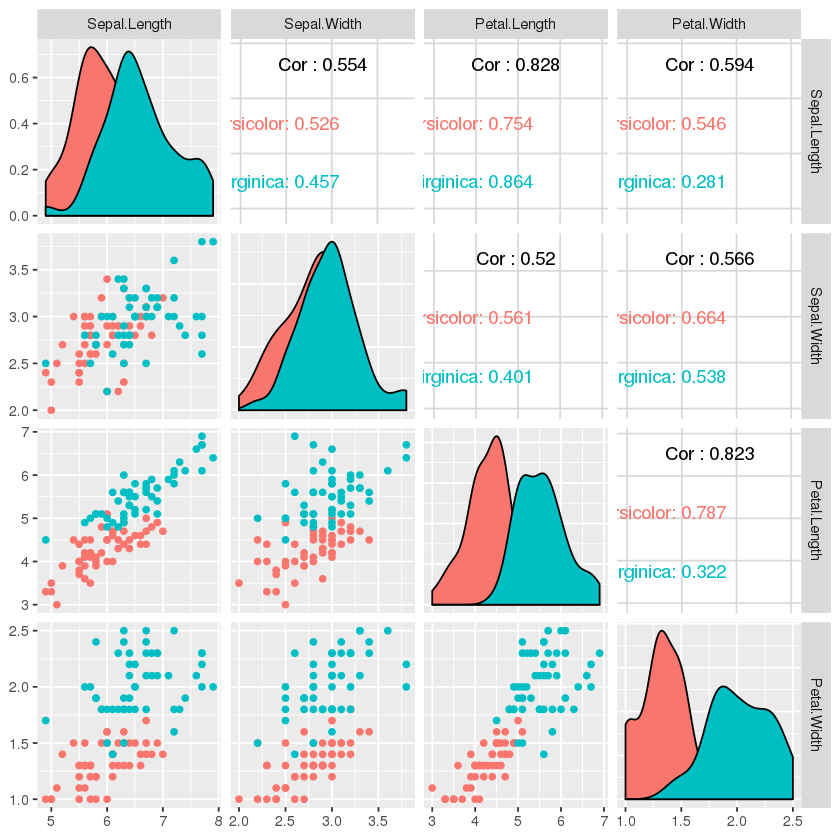

In [20]:
GGally::ggpairs(df, columns = 1:4, ggplot2::aes(color = Species))

## More reading

* 在[Jupyter Notebook](./8.1-machine-learning-with-r.ipynb)上运行本教程代码（需要安装Jupyter和irkernel）

* 本教程代码参考[链接](https://www.blopig.com/blog/2017/04/a-very-basic-introduction-to-random-forests-using-r/)

* 其他机器学习模型相关[代码](https://github.com/urluzhi/scripts/tree/master/Rscript/machine_learning):  
  - `logistic_regression.R`: Logistic Regression
  - `svm.R`: SVM
  - `plot_result.R`: Plot your training and testing performance
  
* [caret](http://topepo.github.io/caret): 用R实现了大量机器学习模型，并包含一个用GitBook教程。

## Homework

学习和使用教程中的代码，使用下面的数据，练习Random Forest，在training set上训练，在test set上预测，汇报模型的prediction performance: 包括 accuracy, sensitivity, specificity, roc_auc等指标，绘制ROC曲线。

  > * **作业要求** ：上交一个文档汇报prediction performance，并解释如上指标所代表的意义，附ROC曲线并解释其意义。
  > * 规定**正样本**为benign，**负样本**为malignant
  > * 训练集和测试集划分参考教程中的80%/20%划分方式，汇报测试集上的指标
  > * 在程序运行最开头加上`set.seed(1234)`。产生最终结果之前把整个代码运行一遍，保证结果可重复性。

请采用`mlbench`包中的数据集`BreastCancer`：

In [21]:
data('BreastCancer')
head(BreastCancer)

Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
1000025,5,1,1,1,2,1,3,1,1,benign
1002945,5,4,4,5,7,10,3,2,1,benign
1015425,3,1,1,1,2,2,3,1,1,benign
1016277,6,8,8,1,3,4,3,7,1,benign
1017023,4,1,1,3,2,1,3,1,1,benign
1017122,8,10,10,8,7,10,9,7,1,malignant


构建模型之前，需要用以下代码产生所需数据集：

In [22]:
# 去除含有缺失值的样本
df <- na.omit(BreastCancer)
# 去除Id和Class两列，产生输入矩阵
all_data <- df[, 2:(ncol(df) - 1)]
# 把Class这一列作为要预测的类别
all_classes <- df$Class

输入为9个特征，均为整数。

输出为两个类别，良性（benign）和恶性（malignant）。

以下时各特征的含义：

* `Cl.thickness`: Clump Thickness
* `Cell.size`: Uniformity of Cell Size
* `Cell.shape`: Uniformity of Cell Shape
* `Marg.adhesion`: Marginal Adhesion
* `Epith.c.size`: Single Epithelial Cell Size
* `Bare.nuclei`: Bare Nuclei
* `Bl.cromatin`: Bland Chromatin
* `Normal.nucleoli`: Normal Nucleoli
* `Mitoses`: Mitoses

如需了解更多关于`BreastCancer`数据集信息，可参考[mlbench](https://cran.r-project.org/web/packages/mlbench/index.html)的文档。